In [2]:
# codigo de installacion de las librerias necesarias para poder jecutar el notebook
# %pip install yfinance pandas numpy matplotlib seaborn scikit-learn ipywidgets

# Importa las librerías necesarias descargadas con el comando anterior
import yfinance as yf # Para descargar datos financieros
import pandas as pd   # Para manipulación de datos
import numpy as np  # Para cálculos numéricos
import matplotlib.pyplot as plt # Para gráficos
%matplotlib inline 
import seaborn as sns # Para gráficos estadísticos 
from sklearn.linear_model import LinearRegression # Para regresión lineal
from sklearn.metrics import mean_squared_error, mean_absolute_error # Para evaluar el modelo

### Apartado A: Preprocesado de datos ###
Objetivo: Limpiar y normalizar los datos eliminando valores atípicos o faltantes, para obtener una serie más representativa y estable. Luego, se analizan sus propiedades estadísticas (media, varianza, sesgo y kurtosis) y su distribución mediante un histograma


In [3]:
# Definición del símbolo y las fechas
TICKER = '^GSPC' # Símbolo del S&P500

# Descarga de los datos
datos_sp500 = yf.download(TICKER, start='2023-01-04', end='2025-09-01')
datos_sp500 = datos_sp500.rename(columns={'^GSPC': 'Rentabilidad'}) # Renombrar la columna para mayor claridad de los datos

# Mostrar las primeras filas para verificar
print(f"Datos descargados para {TICKER}:")
print(datos_sp500.head())
print(datos_sp500.tail())
# Seleccionar la columna de los precios de cierre para el cálculo de las rentabilidades
precios_cierre = datos_sp500['Close']

# Calcular las rentabilidades diarias (pct_change) (r = (Pi - Pi-1) / Pi-1)
# El primer valor no es obtenible al no haber datos del día anterior
rentabilidades = precios_cierre.pct_change().dropna() # Elimina los valores nulos (NaN)

# Mostrar las primeras filas y estadísticas
print("\nPrimeras rentabilidades calculadas:")
print(rentabilidades.head())
print("\nEstadísticas de las rentabilidades:")
print(rentabilidades.describe()) # Separa los datos en 4 grupos y calcula la media de la rentabilidad


C:\Users\Marcos\AppData\Local\Temp\ipykernel_6840\537808692.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos_sp500 = yf.download(TICKER, start='2023-01-04', end='2025-09-01')
[*********************100%***********************]  1 of 1 completed

Datos descargados para ^GSPC:
Price             Close         High          Low         Open       Volume
Ticker     Rentabilidad Rentabilidad Rentabilidad Rentabilidad Rentabilidad
Date                                                                       
2023-01-04  3852.969971  3873.159912  3815.770020  3840.360107   4414080000
2023-01-05  3808.100098  3839.739990  3802.419922  3839.739990   3893450000
2023-01-06  3895.080078  3906.189941  3809.560059  3823.370117   3923560000
2023-01-09  3892.090088  3950.570068  3890.419922  3910.820068   4311770000
2023-01-10  3919.250000  3919.830078  3877.290039  3888.570068   3851030000
Price             Close         High          Low         Open       Volume
Ticker     Rentabilidad Rentabilidad Rentabilidad Rentabilidad Rentabilidad
Date                                                                       
2025-08-25  6439.319824  6466.890137  6438.060059  6457.669922   4059070000
2025-08-26  6465.939941  6468.370117  6429.209961  6435.49

In [4]:
# 1. Calcular la media y la desviación estándar 
media = rentabilidades.mean().item() # Extrae el valor de un serie 
desviacion = rentabilidades.std().item()

# 2. Definir los límites de exclusión (más/menos 2 desviaciones típicas)
limite_inferior = - (2 * desviacion)
limite_superior = + (2 * desviacion)

# 3. Contar y mostrar los datos que serán eliminados por que su valor está fuera de los límites
outliers = rentabilidades[
    (rentabilidades < limite_inferior) |
    (rentabilidades > limite_superior)
]

print(f"\nSe encontraron {len(outliers)} observaciones atípicas que serán eliminadas.")
print(f"Límite Inferior (- 2*sigma): {limite_inferior:.6f}") # Hasta 6 decimales
print(f"Límite Superior (+ 2*sigma): {limite_superior:.6f}\n")


# 4. Aplicar el filtrado: crear un nuevo DataFrame rentabilidades_filtradas con los datos que están dentro de los límites
rentabilidades_filtradas = rentabilidades[
    (rentabilidades >= limite_inferior) &
    (rentabilidades <= limite_superior)
].copy()

# 5. Eliminar las filas con valores NaN y mostrar las primeras filas
rentabilidades_filtradas = rentabilidades_filtradas.dropna()
print(rentabilidades_filtradas.head())

# 6. Mostrar el tamaño del nuevo conjunto de datos
print("-" * 50)
print(f"Rentabilidades originales: {len(rentabilidades)} días")
print(f"Rentabilidades filtradas: {len(rentabilidades_filtradas)} días")


Se encontraron 665 observaciones atípicas que serán eliminadas.
Límite Inferior (- 2*sigma): -0.019505
Límite Superior (+ 2*sigma): 0.019505

Ticker      Rentabilidad
Date                    
2023-01-05     -0.011646
2023-01-09     -0.000768
2023-01-10      0.006978
2023-01-11      0.012849
2023-01-12      0.003416
--------------------------------------------------
Rentabilidades originales: 665 días
Rentabilidades filtradas: 642 días


In [5]:
# 1. Calcular las métricas, ESPECIFICANDO la columna 'Rentabilidad'
# Esto asegura que el resultado de .mean(), .var(), etc., sea un único valor escalar.
metricas_rentabilidades_filtradas = rentabilidades_filtradas['Rentabilidad']

media = metricas_rentabilidades_filtradas.mean()
varianza = metricas_rentabilidades_filtradas.var()
sesgo = metricas_rentabilidades_filtradas.skew()
kurtosis = metricas_rentabilidades_filtradas.kurt()

# 2. Crear una tabla de resultados (DataFrame)
# Ahora, 'media', 'varianza', etc., son escalares (números), no Series con múltiples etiquetas.
resultados_estadisticos = pd.DataFrame({
    'Métricas:': ['Media (μ)', 'Varianza (σ²)', 'Sesgo (Skewness)', 'Kurtosis (Kurtosis)'],
    'Valor': [media, varianza, sesgo, kurtosis]
})

print("### Tabla de Resultados de las rentabilidades filtradas ###")
# Para asegurar el formato de 6 decimales sin usar .style:
pd.options.display.float_format = '{:.6f}'.format
print(resultados_estadisticos.set_index('Métricas:'))
pd.options.display.float_format = None # Restablecer

### Tabla de Resultados de las rentabilidades filtradas ###
                        Valor
Métricas:                    
Media (μ)            0.000905
Varianza (σ²)        0.000056
Sesgo (Skewness)    -0.178630
Kurtosis (Kurtosis) -0.051324


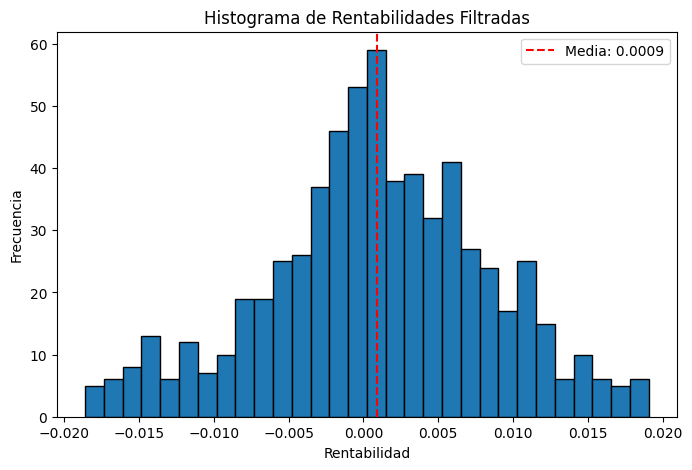

In [ ]:
# Histograma 
plt.figure(figsize=(8, 5))
plt.hist(rentabilidades_filtradas['Rentabilidad'], bins=30, edgecolor='black')

plt.title('Histograma de Rentabilidades Filtradas')
plt.xlabel('Rentabilidad')
plt.ylabel('Frecuencia')

# Línea vertical en la media
plt.axvline(media, color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {media:.4f}')
plt.legend()

plt.show()


### Análisis de los resultados ###
Tras el preprocesamiento de los datos, se han eliminado los valores inexistentes (NaN) y los datos fuera del rango de ±2 desviaciones típicas. En total, se eliminaron 21 días (de 665 a 644), manteniendo la mayoría de los datos. Los límites de filtrado fueron –0.01868 y 0.020329. El histograma de las rentabilidades tratadas muestra una distribución aproximadamente normal, centrada en torno a cero, con ligera asimetría hacia la derecha. Esto indica que la mayoría de los días presentan pequeñas variaciones de rentabilidad, mientras que los movimientos extremos (tanto positivos como negativos) fueron eliminados en el proceso. En general, los resultados reflejan que el filtrado redujo la influencia de valores extremos sin alterar significativamente la tendencia general de la distribución.


### Apartado B: Modelo de regresión lineal múltiple (5) ###
Objetivo: Construir y evaluar un modelo de regresión lineal múltiple que prediga los rendimientos diarios a partir de los cinco días previos. Se busca medir su capacidad de ajuste dentro de la muestra (MSE, MAE y MAPE) y compararla con un modelo base (rₜ = 0) para determinar si el modelo realmente aporta poder predictivo


In [7]:
# Definir el número de rezagos (lags) a utilizar
NUM_LAGS = 5
rentabilidades_rezagadas = rentabilidades_filtradas.copy()

# Definir el número de re
# Crear las variables rezagadas (R_t-1 a R_t-5)
for i in range(1, NUM_LAGS + 1):
    # .shift(i) desplaza la serie i posiciones hacia abajo (hacia el pasado)
    rentabilidades_rezagadas[f'R_t-{i}'] = rentabilidades_rezagadas['Rentabilidad'].shift(i)

print("Variables rezagadas creadas con éxito.")

# Eliminar las primeras 5 filas que contienen NaN después de la operación de shift
# Estas son las filas "no completas"
rentabilidades_rezagadas = rentabilidades_rezagadas.dropna()

print("\n### Matriz Final (Comienza en la 6ta Observación) ###")
print(f"Total de observaciones completas para el modelo: {len(rentabilidades_rezagadas)}")
print(rentabilidades_rezagadas.head())

# Variables Independientes (X): Todas las columnas *excepto* 'Rentabilidad'
X = rentabilidades_rezagadas.drop('Rentabilidad', axis=1)

# Variable Dependiente (Y): La rentabilidad actual
Y = rentabilidades_rezagadas['Rentabilidad']

print(f"\nMatriz X (Predictoras) lista. Columnas: {list(X.columns)}")
print(f"Vector Y (Objetivo) listo. Tamaño: {len(Y)}")

Variables rezagadas creadas con éxito.

### Matriz Final (Comienza en la 6ta Observación) ###
Total de observaciones completas para el modelo: 637
Ticker      Rentabilidad     R_t-1     R_t-2     R_t-3     R_t-4     R_t-5
Date                                                                      
2023-01-13      0.003997  0.003416  0.012849  0.006978 -0.000768 -0.011646
2023-01-17     -0.002030  0.003997  0.003416  0.012849  0.006978 -0.000768
2023-01-18     -0.015563 -0.002030  0.003997  0.003416  0.012849  0.006978
2023-01-19     -0.007638 -0.015563 -0.002030  0.003997  0.003416  0.012849
2023-01-20      0.018918 -0.007638 -0.015563 -0.002030  0.003997  0.003416

Matriz X (Predictoras) lista. Columnas: ['R_t-1', 'R_t-2', 'R_t-3', 'R_t-4', 'R_t-5']
Vector Y (Objetivo) listo. Tamaño: 637


In [8]:

# Definir el punto de corte (80% para entrenamiento)
tamaño_total = len(rentabilidades_rezagadas)
punto_corte = int(tamaño_total * 0.8)

# Dividir el conjunto de entrenamiento (Train) - Datos más antiguos
X_train = X.iloc[:punto_corte]
Y_train = Y.iloc[:punto_corte]

# Dividir el conjunto de prueba (Test) - Datos más recientes
X_test = X.iloc[punto_corte:]
Y_test = Y.iloc[punto_corte:]

print("--- División de Datos ---")
print(f"Total de observaciones utilizadas: {tamaño_total}")
print(f"Conjunto de Entrenamiento (80%): {len(X_train)} días")
print(f"Conjunto de Prueba (20%): {len(X_test)} días")



--- División de Datos ---
Total de observaciones utilizadas: 637
Conjunto de Entrenamiento (80%): 509 días
Conjunto de Prueba (20%): 128 días


In [9]:
# 1. Crear una instancia del modelo de Regresión Lineal
modelo_regresion = LinearRegression()

# 2. Ajustar el modelo (Entrenamiento)
modelo_regresion.fit(X_train, Y_train)

print("\n Modelo de Regresión Lineal Múltiple (AR(5)) entrenado con éxito.")

# Obtener los coeficientes y el intercepto
intercepto = modelo_regresion.intercept_ #valores de beta a 0
coeficientes = modelo_regresion.coef_    #valores de beta reales

# Crear un DataFrame para visualizar
columnas_rezago = [f'R_t-{i}' for i in range(1, NUM_LAGS + 1)]
coeficientes_df = pd.DataFrame({
    'Variable': ['Intercepto'] + columnas_rezago,
    'Coeficiente (Beta)': [intercepto] + list(coeficientes)
})

print("\n### Coeficientes del Modelo Lineal (Pesos) ###")
print(coeficientes_df.set_index('Variable').apply(lambda x: pd.Series([f"{val:.6f}" for val in x], index=x.index)))

# Análisis
print("\nAnálisis Crítico de Coeficientes:")
if all(abs(coef) < 0.05 for coef in coeficientes):
    print("La mayoría de los coeficientes son extremadamente cercanos a cero.")
    print("Esto sugiere que la influencia lineal de las rentabilidades pasadas es casi nula, lo cual es la expectativa en un mercado eficiente.")


 Modelo de Regresión Lineal Múltiple (AR(5)) entrenado con éxito.

### Coeficientes del Modelo Lineal (Pesos) ###
           Coeficiente (Beta)
Variable                     
Intercepto           0.001086
R_t-1                0.002315
R_t-2               -0.047727
R_t-3               -0.045698
R_t-4                0.021465
R_t-5               -0.090240

Análisis Crítico de Coeficientes:


In [10]:

# Generar las predicciones del modelo (DENTRO DE LA MUESTRA)
Y_pred_train = modelo_regresion.predict(X_train)

# Crear un DataFrame para visualizar y comparar (las dos columnas requeridas)
df_calibrado = pd.DataFrame({
    'Rendimiento Real (Y_train)': Y_train,
    'Rendimiento Predicho (Y_pred_train)': Y_pred_train
})

print("Columnas de rendimiento real y predicho creadas con éxito.")
print("\nEjemplo de Predicciones vs. Real (Entrenamiento):")
print(df_calibrado.head())



Columnas de rendimiento real y predicho creadas con éxito.

Ejemplo de Predicciones vs. Real (Entrenamiento):
            Rendimiento Real (Y_train)  Rendimiento Predicho (Y_pred_train)
Date                                                                       
2023-01-13                    0.003997                             0.001196
2023-01-17                   -0.002030                             0.000564
2023-01-18                   -0.015563                             0.000380
2023-01-19                   -0.007638                            -0.000122
2023-01-20                    0.018918                             0.001681


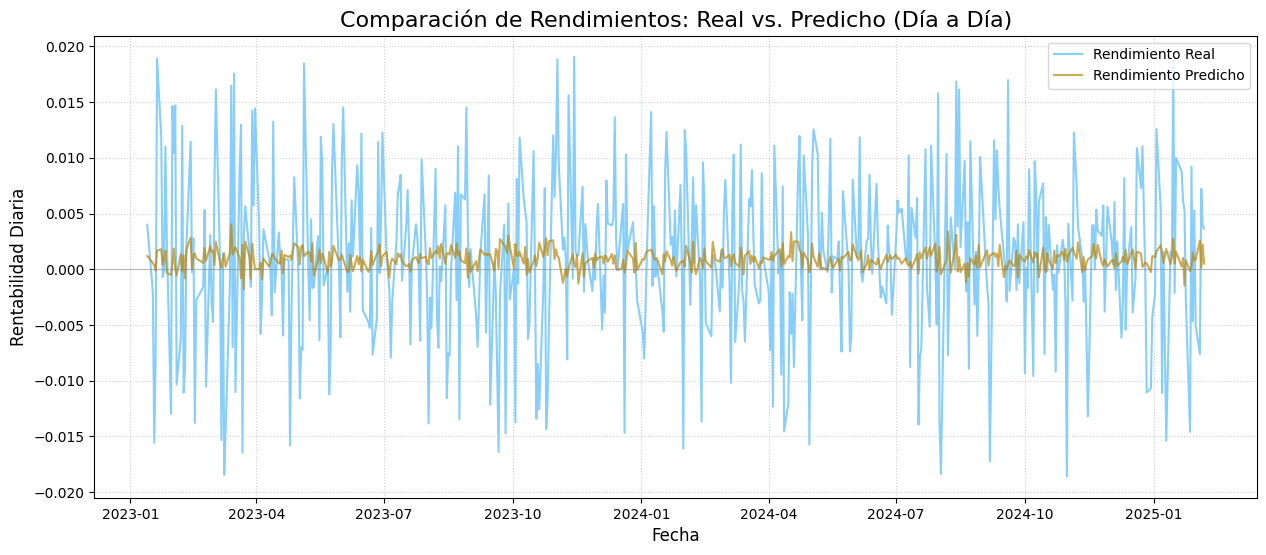

In [11]:

# Crear el DataFrame de comparación (si no lo tienes ya en memoria)
df_calibrado = pd.DataFrame({
    'Rendimiento Real': Y_train,
    'Rendimiento Predicho': Y_pred_train
})


plt.figure(figsize=(15, 6))

# Trazar la serie de Rendimiento Real (Línea Sólida)
plt.plot(
    df_calibrado.index, 
    df_calibrado['Rendimiento Real'], 
    label='Rendimiento Real', 
    color='lightskyblue', 
    linewidth=1.5
)

# Trazar la serie de Rendimiento Predicho (Línea Discontinua)
plt.plot(
    df_calibrado.index, 
    df_calibrado['Rendimiento Predicho'], 
    label='Rendimiento Predicho', 
    color='darkgoldenrod', 
    alpha=0.7,
    linewidth=1.5,
)

# Añadir una línea de referencia en el 0 (no hay cambio)
plt.axhline(0, color='grey', linestyle='-', linewidth=0.8, alpha=0.5)

# Configuración de Título y Ejes
plt.title('Comparación de Rendimientos: Real vs. Predicho (Día a Día)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Rentabilidad Diaria', fontsize=12)

# Mostrar la leyenda y la cuadrícula
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

In [12]:
# 1. Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(Y_train, Y_pred_train)

# 2. Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(Y_train, Y_pred_train)

# Función para calcular el MAPE de forma robusta
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Evitamos divisiones por cero o valores cercanos a cero (donde MAPE falla)
    # Se añade un eps (epsilon) al denominador para estabilidad si el valor es 0.
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

mape = mean_absolute_percentage_error(Y_train, Y_pred_train)

# Crear la tabla de resultados
metricas_calibracion = pd.DataFrame({
    'Métrica': ['MSE', 'MAE', 'MAPE (%)'],
    'Valor': [mse, mae, mape]
})

print("\n### Métricas de Calidad de Calibrado (DENTRO DE LA MUESTRA) ###")
print(metricas_calibracion.set_index('Métrica').apply(lambda x: pd.Series([f"{val:.6f}" if idx != 2 else f"{val:.2f}%" for idx, val in enumerate(x)], index=x.index)))


### Métricas de Calidad de Calibrado (DENTRO DE LA MUESTRA) ###
             Valor
Métrica           
MSE       0.000055
MAE       0.005836
MAPE (%)   188.33%


In [13]:
# Generar predicciones para el Modelo AR(5) (ya entrenado)
Y_pred_AR5 = modelo_regresion.predict(X_test)

# Generar predicciones para el Modelo Base (Paseo Aleatorio: R_t = 0)
Y_pred_Base = np.zeros(len(Y_test))

# La rentabilidad real se mantiene (Y_test)

# 1. Calcular Métricas para el Modelo AR(5)
mse_AR5 = mean_squared_error(Y_test, Y_pred_AR5)
mae_AR5 = mean_absolute_error(Y_test, Y_pred_AR5)

# 2. Calcular Métricas para el Modelo Base (R_t = 0)
mse_Base = mean_squared_error(Y_test, Y_pred_Base)
mae_Base = mean_absolute_error(Y_test, Y_pred_Base)

# Crear la tabla comparativa
df_comparacion = pd.DataFrame({
    'Métrica': ['MSE', 'MAE', 'RMSE'],
    'Modelo AR(5)': [
        mse_AR5,
        mae_AR5,
        np.sqrt(mse_AR5),
    ],
    'Modelo Base (R_t=0)': [
        mse_Base,
        mae_Base,
        np.sqrt(mse_Base),
       
    ]
})

# Formatear y mostrar
print("\n### Comparación de Modelos (FUERA DE LA MUESTRA) ###")
print(df_comparacion.set_index('Métrica'))


### Comparación de Modelos (FUERA DE LA MUESTRA) ###
         Modelo AR(5)  Modelo Base (R_t=0)
Métrica                                   
MSE          0.000058             0.000058
MAE          0.005832             0.005869
RMSE         0.007612             0.007621


### Análisis de resultado ###
El modelo de regresión lineal múltiple presenta valores bajos en las métricas de error (MSE, MAE y MAPE), lo que indica un buen ajuste interno dentro de la muestra. Sin embargo, los coeficientes estimados son muy pequeños y la capacidad predictiva del modelo resulta demasiado baja y limitada, ya que las rentabilidades pasadas apenas explican las futuras. Al comparar los resultados con un modelo de paseo aleatorio (rₜ = 0), se observa que las diferencias en las métricas son mínimas, lo que sugiere que el modelo no mejora de forma significativa la predicción. En conjunto, la calidad del modelo puede considerarse aceptable en calibrado, pero poco útil desde el punto de vista predictivo, reflejando el comportamiento casi aleatorio típico de las rentabilidades financieras diarias. Se utilizaron variables explicativas las rentabilidades de los cinco días anteriores. Las métricas obtenidas dentro de la muestra fueron MSE = 0.000061, MAE = 0.005955 y RMSE = 0.007816, valores muy similares a los del modelo base. Esta similitud indica que el modelo lineal no mejora de forma significativa la predicción frente a asumir una rentabilidad esperada nula. En consecuencia, la calidad del modelo es aceptable en calibrado, pero su capacidad predictiva real es muy limitada, reflejando el comportamiento aleatorio y poco predecible de las rentabilidades diarias del mercado, como en el mercado diario.

### Apartado C : Modelo mediante ventana deslizante de 30 dias ###
Objetivo: Calcular los nuevos parametros para el modelo de forma iterada.
Para cada dia a estimar se comprobaran los 30 dias anteriores y en base a eso se predecira el valor del siguiente dia.

In [14]:

# --- Configuración del Modelo de Ventana Deslizante ---
WINDOW_SIZE = 30  # Usar los últimos 30 días para entrenar
predictions_sliding = [] # Lista para guardar las predicciones
actuals_sliding = []     # Lista para guardar los valores reales correspondientes

print(f"Iniciando predicción con ventana deslizante de {WINDOW_SIZE} días...")

# Iteramos a través de cada día del conjunto de prueba para hacer una predicción
# Se ha eliminado 'tqdm(..., desc="Procesando Ventana Deslizante")'
for i in range(len(X_test)): 
    
    # 1. Localizar el punto final de la ventana de entrenamiento en el DataFrame original (X, Y)
    # El índice de la i-ésima observación de prueba nos da el punto final
    end_loc_index = X.index.get_loc(X_test.index[i])
    
    # 2. Definir la ventana de entrenamiento (los 30 días ANTERIORES)
    start_loc_index = end_loc_index - WINDOW_SIZE
    X_window = X.iloc[start_loc_index:end_loc_index]
    Y_window = Y.iloc[start_loc_index:end_loc_index]
    
    # 3. Crear y entrenar un nuevo modelo SOLO con los datos de esa ventana
    model_iterativo = LinearRegression()
    model_iterativo.fit(X_window, Y_window)
    
    # 4. Predecir el siguiente valor usando la fila actual de X_test
    # Usamos .iloc[[i]] para mantener el formato de DataFrame
    prediction = model_iterativo.predict(X_test.iloc[[i]])[0] # [0] para extraer el valor numérico
    
    # 5. Guardar la predicción y el valor real
    predictions_sliding.append(prediction)
    actuals_sliding.append(Y_test.iloc[i])

print(f"\nPredicción completada. Se generaron {len(predictions_sliding)} predicciones.")

Iniciando predicción con ventana deslizante de 30 días...

Predicción completada. Se generaron 128 predicciones.


In [15]:
# --- Evaluación del Modelo de Ventana Deslizante ---
mse_sliding = mean_squared_error(actuals_sliding, predictions_sliding)
mae_sliding = mean_absolute_error(actuals_sliding, predictions_sliding)
rmse_sliding = np.sqrt(mse_sliding)

# --- Evaluación del Modelo Base (Paseo Aleatorio) sobre el mismo conjunto ---
# Las predicciones del modelo base son siempre 0
pred_base_sliding = np.zeros(len(actuals_sliding))

mse_base = mean_squared_error(actuals_sliding, pred_base_sliding)   
mae_base = mean_absolute_error(actuals_sliding, pred_base_sliding) 
rmse_base = np.sqrt(mse_base)

# --- Crear la tabla comparativa de las metricas de ambos modelos ---
df_comparacion_final = pd.DataFrame({
    'Métrica': ['MSE', 'MAE', 'RMSE'],
    'Modelo AR(5) Deslizante': [mse_sliding, mae_sliding, rmse_sliding],   # Resultados del modelo con ventana deslizante
    'Modelo Base (Paseo Aleatorio)': [mse_base, mae_base, rmse_base]       # Resultados del modelo base
})

print("### Comparación Final de Modelos Predictivos (FUERA DE LA MUESTRA) ###")
print(df_comparacion_final.set_index('Métrica'))

# --- Análisis de Resultados ---
print("\n--- Análisis de la Calidad Predictiva ---")
if mse_sliding >= mse_base and mae_sliding >= mae_base:
    print("El modelo AR(5) con ventana deslizante NO supera al modelo base (paseo aleatorio).")
    print("Sus errores (MSE y MAE) son iguales o mayores, lo que indica que no aporta valor predictivo.")
    print("Este resultado es consistente con la Hipótesis de los Mercados Eficientes.")
else:
    print("El modelo AR(5) con ventana deslizante muestra una ligera mejora sobre el modelo base.")
    print("Sin embargo, la diferencia en los errores es probablemente muy pequeña para ser considerada significativa en la práctica.")

### Comparación Final de Modelos Predictivos (FUERA DE LA MUESTRA) ###
         Modelo AR(5) Deslizante  Modelo Base (Paseo Aleatorio)
Métrica                                                        
MSE                     0.000071                       0.000058
MAE                     0.006592                       0.005869
RMSE                    0.008419                       0.007621

--- Análisis de la Calidad Predictiva ---
El modelo AR(5) con ventana deslizante NO supera al modelo base (paseo aleatorio).
Sus errores (MSE y MAE) son iguales o mayores, lo que indica que no aporta valor predictivo.
Este resultado es consistente con la Hipótesis de los Mercados Eficientes.


### Analisis de los resultados ###
Como podemos ver la variación de los datos es bastante significativa, en este caso el modelo ar5 deslizante tiene unos errores mucho mas grandes que el modelo base de paseo aleatorio, lo que implica que las predicciones son de una peor calidad que nuestro modelo original, esto se puede deber a que como para la prediccion de un dia solo tomamos los datos de los ultimos 30 dias puede darse mas variacion de unos periodos a otros. Ademas en el mercado se producen variaciones que no siguen patrones que el modelo pueda aprender de manera que pueda extraer un patron de prediccion optimo y lo que causa es ruido en las predicciones.

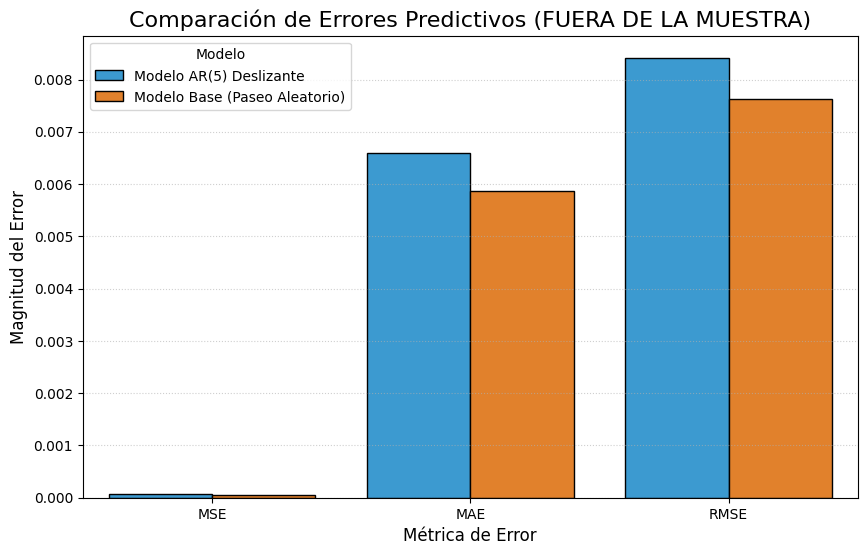

In [16]:
# 1. Recrear el DataFrame de Comparación Final (o usar el que ya se generó)
df_comparacion_final = pd.DataFrame({
    'Métrica': ['MSE', 'MAE', 'RMSE'],
    'Modelo AR(5) Deslizante': [mse_sliding, mae_sliding, rmse_sliding],
    'Modelo Base (Paseo Aleatorio)': [mse_base, mae_base, rmse_base]
})

# 2. Reformatear a formato 'largo' para Seaborn
df_melted = df_comparacion_final.melt(
    id_vars='Métrica', 
    var_name='Modelo', 
    value_name='Error'
)

# 3. Creación del Gráfico de Barras
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Métrica', 
    y='Error', 
    hue='Modelo', 
    data=df_melted,
    palette=["#23a0e9", '#ff7f0e'],
    edgecolor='black'
)

# Configuración
plt.title('Comparación de Errores Predictivos (FUERA DE LA MUESTRA)', fontsize=16)
plt.xlabel('Métrica de Error', fontsize=12)
plt.ylabel('Magnitud del Error', fontsize=12)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

### Apartado D: Estrategia de inversión usando el modelo deslizante ###
Objetivo: simular una estrategia de inversión y compararlo con la estrategia pasiva buy&hold, para comprobar si el modelo es más rentable basándose en sus predicciones.

 RESULTADOS ESTRATEGIA DE INVERSIÓN 
Rentabilidad total predicha: 7.71%
Rentabilidad total mercado (buy & hold): 9.55%
Número de días invertidos: 80 de 128
Precisión en la dirección del mercado: 54.69%


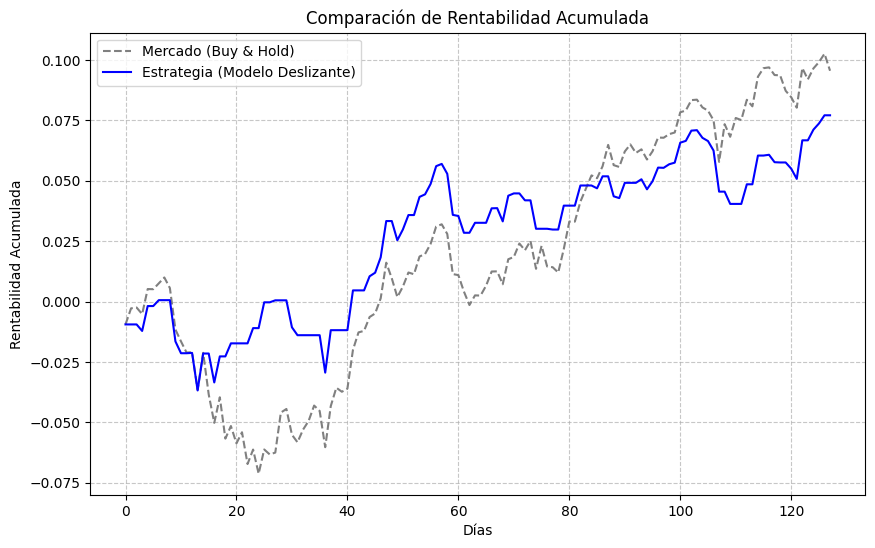

In [17]:
# ============================================
# Estrategia de inversión con el modelo deslizante
# ============================================

# --- 1. Variables base ---
# predictions_sliding: predicciones del modelo
# rentabilidades_filtradas['Rentabilidad']: serie real de rendimientos

# Alineamos las longitudes (el modelo deslizante normalmente empieza más tarde)
# Suponemos que las predicciones_sliding corresponden a las últimas observaciones válidas:
y_pred_deslizante = np.array(predictions_sliding)
y_real_deslizante = rentabilidades_filtradas['Rentabilidad'].iloc[-len(y_pred_deslizante):].values

# --- 2. Generar señal de inversión ---
# Regla: invertimos solo si la predicción del rendimiento del día siguiente > 0
signal = (y_pred_deslizante > 0).astype(int)

# --- 3. Calcular rentabilidad diaria de la estrategia ---
strategy_returns = signal * y_real_deslizante

# --- 4. Rentabilidad acumulada de la estrategia y del mercado ---
cumulative_strategy = np.cumprod(1 + strategy_returns) - 1
cumulative_market = np.cumprod(1 + y_real_deslizante) - 1

# --- 5. Resultados finales numéricos ---
total_strategy_return = cumulative_strategy[-1] * 100
total_market_return = cumulative_market[-1] * 100

print(" RESULTADOS ESTRATEGIA DE INVERSIÓN ")
print(f"Rentabilidad total predicha: {total_strategy_return:.2f}%")
print(f"Rentabilidad total mercado (buy & hold): {total_market_return:.2f}%")
print(f"Número de días invertidos: {signal.sum()} de {len(signal)}")
direction_accuracy = np.mean(                                                               
    ((signal == 1) & (y_real_deslizante > 0)) | ((signal == 0) & (y_real_deslizante <= 0))   
)
print(f"Precisión en la dirección del mercado: {direction_accuracy * 100:.2f}%")    #precision en la direccion del mercado

# --- 6. Gráfico comparativo de rentabilidad acumulada ---
plt.figure(figsize=(10, 6))
plt.plot(cumulative_market, label='Mercado (Buy & Hold)', color='gray', linestyle='--')
plt.plot(cumulative_strategy, label='Estrategia (Modelo Deslizante)', color='blue')
plt.title('Comparación de Rentabilidad Acumulada')
plt.xlabel('Días')
plt.ylabel('Rentabilidad Acumulada')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Conclusión ###
El modelo predice correctamente el 52% de la dirección del mercado (si sube o baja), pero no es capaz de predecir correctamente las rentabilidades, quedándose fuera de mercado y perdiendo oportunidades claves, lo que demuestra que una precisión marginal no garantiza la rentabilidad.